In [ ]:
# only if using google colab gpu
!nvidia-smi

Sat Dec 24 18:15:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    34W /  70W |  14632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# mount google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import data
import numpy as np

In [ ]:
# specifying the batch size and image size
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

# specifying paths for train, validation and test directory
train_dir = '/content/drive/MyDrive/data_sd_new/train'
valid_dir = '/content/drive/MyDrive/data_sd_new/val'
test_dir = '/content/drive/MyDrive/data_sd_new/test'

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2012 files belonging to 36 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 395 files belonging to 36 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 108 files belonging to 36 classes.


### Displaying a few images

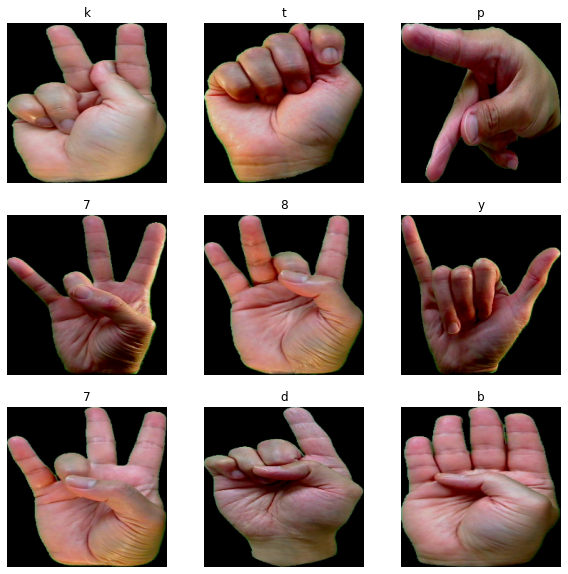

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

### Optimise data loading

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

*   Random Horizontal Flip
*   Random Contrast
*   Random Brightness
*   Random Rotation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(factor=0.7),
  tf.keras.layers.RandomBrightness(factor=0.7),
  tf.keras.layers.RandomRotation(0.1)
])

### Visualise data augmentation methods

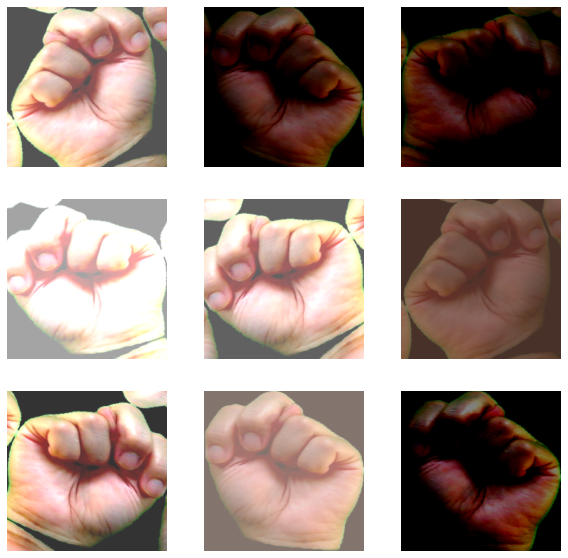

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Pre-process the inputs


The preprocessing logic has been included in the efficientnet model implementation. Users are no longer required to call this method to normalize the input data. This method does nothing and only kept as a placeholder to align the API surface between old and new version of model.

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

### Rescaling/Normalising the images

In [ ]:
rescale = tf.keras.layers.Rescaling(1./255)

## Base Model Creation (EfficientNet B7)

In [ ]:
# Create the base model from the pre-trained model EfficientNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')

258076736/258076736 [==============================] - 13s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2560)


Setting the trainable layers in the base model to false as it has been previosly trained on the Imagenet Dataset.

In [ ]:
base_model.trainable = False

### Base Model Summary

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2560)


In [ ]:
prediction_layer = tf.keras.layers.Dense(36)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 36)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compiling the model


*   Learning rate has been set to 0.0001
*   Sparse Categorical Crossentropy is used becuase it is a multiclass categorical problem
*   Accuracy is defined as the metric





In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 36)                92196     
                                                             

Only 92,196 paramters out of 64,097,687 are trainable. This is because we have earlier set the training layers to false.

In [ ]:
len(model.trainable_variables)

2

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  814


In [ ]:
initial_epochs = 20

# loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

## Training the model

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


126/126 [==============================] - 690s 5s/step - loss: 3.4974 - accuracy: 0.0691 - val_loss: 3.3365 - val_accuracy: 0.1873
Epoch 2/20
126/126 [==============================] - 48s 378ms/step - loss: 3.2691 - accuracy: 0.1754 - val_loss: 3.1167 - val_accuracy: 0.3013
Epoch 3/20
126/126 [==============================] - 48s 381ms/step - loss: 3.0455 - accuracy: 0.2818 - val_loss: 2.9342 - val_accuracy: 0.3797
Epoch 4/20
126/126 [==============================] - 49s 383ms/step - loss: 2.8835 - accuracy: 0.3330 - val_loss: 2.7779 - val_accuracy: 0.4203
Epoch 5/20
126/126 [==============================] - 49s 382ms/step - loss: 2.7595 - accuracy: 0.3593 - val_loss: 2.6444 - val_accuracy: 0.4962
Epoch 6/20
126/126 [==============================] - 51s 400ms/step - loss: 2.6375 - accuracy: 0.4165 - val_loss: 2.5286 - val_accuracy: 0.5468
Epoch 7/20
126/126 [==============================] - 49s 385ms/step - loss: 2.4995 - accuracy: 0.4583 - val_loss: 2.4253 - val_accuracy: 0.544

Took 32 mins to run epoch 1 to 20

## Visualising accuracy and loss

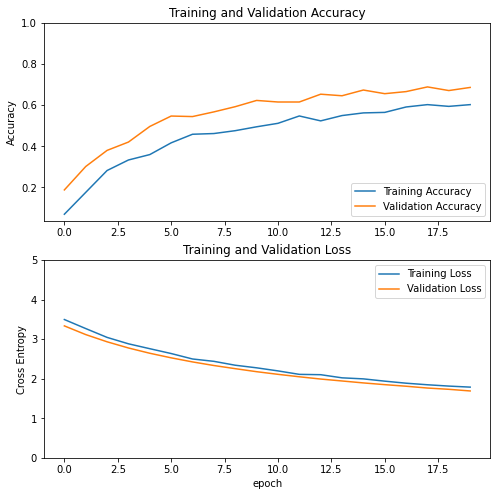

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('train_val_acc_loss_efficientnetB7_before.png', dpi=300)
plt.show()

## Fine Tuning the model
The objective by tuning the model is to increase the accuracy of the model by tuning a few parameters and optimizers.

## Setting trainable layers to True

In [ ]:
base_model.trainable = True

In [ ]:
# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 36)                92196     
                                                             

In [ ]:
len(model.trainable_variables)

711

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


126/126 [==============================] - 205s 1s/step - loss: 1.0076 - accuracy: 0.7247 - val_loss: 0.4480 - val_accuracy: 0.8759
Epoch 21/40
126/126 [==============================] - 150s 1s/step - loss: 0.6227 - accuracy: 0.8181 - val_loss: 0.2750 - val_accuracy: 0.9215
Epoch 22/40
126/126 [==============================] - 149s 1s/step - loss: 0.5103 - accuracy: 0.8360 - val_loss: 0.2151 - val_accuracy: 0.9291
Epoch 23/40
126/126 [==============================] - 150s 1s/step - loss: 0.3977 - accuracy: 0.8718 - val_loss: 0.1875 - val_accuracy: 0.9165
Epoch 24/40
126/126 [==============================] - 152s 1s/step - loss: 0.3289 - accuracy: 0.9001 - val_loss: 0.1566 - val_accuracy: 0.9266
Epoch 25/40
126/126 [==============================] - 151s 1s/step - loss: 0.3402 - accuracy: 0.8971 - val_loss: 0.1374 - val_accuracy: 0.9443
Epoch 26/40
126/126 [==============================] - 150s 1s/step - loss: 0.2661 - accuracy: 0.9150 - val_loss: 0.1044 - val_accuracy: 0.9595
Epoc

Took 1 hour 3 mins to run epoch 20 to 40.

In [ ]:
# combining before and after fine tuning results
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

### Visualising results before and after fine tuning accuracies

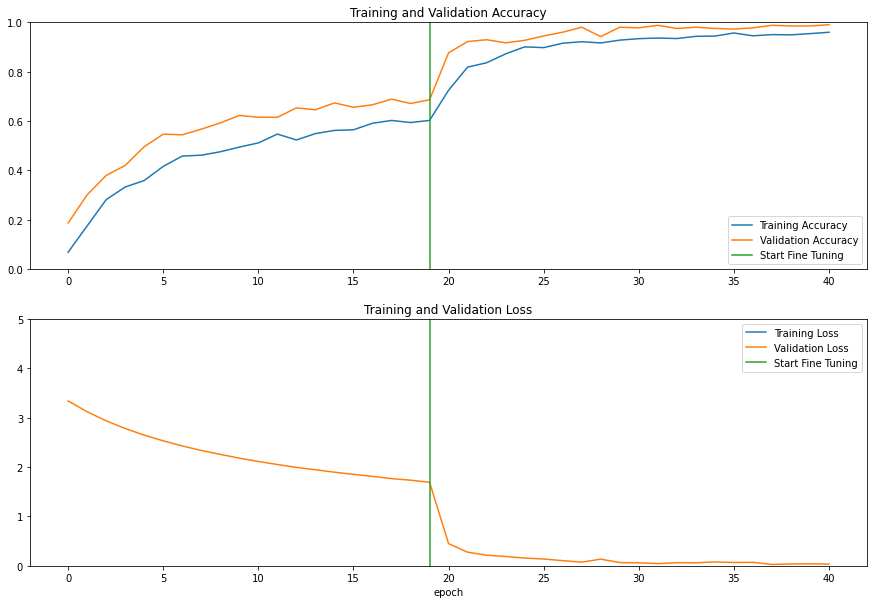

In [ ]:
# Accuracy
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('train_val_acc_loss_efficientnetB7_after.png', dpi=300)
plt.show()

### Obtaining the Test accuracy

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy: {:.4f}' .format(accuracy))

7/7 [==============================] - 34s 191ms/step - loss: 0.0287 - accuracy: 0.9907
Test accuracy: 0.99


Accuracy for Signer Dependent using EfficientNet B5 is **98.15%**.

Time taken: 16 mins + 43 mins = **59 mins**


---


Accuracy for Signer Dependent using EfficientNet B7 is **99.07%**

Time taken: 32 mins + 63 mins = **95 mins** (1h35m)


---


Accuracy Difference: **0.92%**

Time Difference: **36 mins**


## Predicting new images on the trained model

In [ ]:
img_height = 224
img_width = 224

img = tf.keras.utils.load_img(
    '/content/drive/MyDrive/output_ori/nine.jpeg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

FileNotFoundError: ignored

## Save model for deployment

In [ ]:
# from tensorflow.keras.models import load_model

model.save('transfer_learning_efficientnetb7_sd.h5')